# Variational Equations
We work with an two planet system. We vary the initial semi-major axis $a$ of the outer planet. Because the planets interact with each other, the final $x$-position of the inner planet at the end of the simulation will depend on the semi-major axis of the outer planet. We run the simulation once for one $a_0$ and then use first and second order variational equations to predict the final position of the outer plnaet for different $a$s in a neighbourhood of $a_0$. 

To do that, let us first import REBOUND, numpy and matplotlib.

In [1]:
import rebound
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

/Users/rein/git/rebound/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Before using variational equations, let us define a function that calculates the final position of the outer planet as a function of $a$ in the brute-force way:

In [2]:
def run_sim(a):
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=1)
    sim.add(primary=sim.particles[0],m=1e-3, a=a)
    
    sim.integrate(2.*np.pi*10.)
    return sim.particles[1].x

We'll use this function to create a list of *true* final positions to which we later compare our results.

In [3]:
N=400
x_exact = np.zeros((N))
a_grid = np.linspace(1.4,1.7,N)
for i,a in enumerate(a_grid):
    x_exact[i] = run_sim(a)

Running a simulation with variational equations is only slightly more complicated. We start by creating a simulation and adding the three particles (the star and two planets) as before. Note that we initialize the orbit in heliocentric coordinates, telling REBOUND excplicitly that the star is the primary. 

We then add variational particles to the simulation. We vary one paramter ($a$) and thus need only only set. The second order variational equations depend on the first order ones. Thus, when initializing them, one needs to specify the index where the first order variational particles are stored using the 'index_1st_order' parameters.

Then the variational particles are initialized. REBOUND comes with several convenience functions that make varying orbital parameters particularly easy.

The function returns not only the final position, but also the first and second derivates with respect to $a$. 

In [4]:
def run_sim_var(a):
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=1)
    sim.add(primary=sim.particles[0],m=1e-3, a=a)
    var_da = sim.add_variation()
    var_dda = sim.add_variation(order=2, first_order=var_da)
    var_da.init(2, "a")
    var_dda.init(2, "a")
    
    sim.integrate(2.*np.pi*10.)
    return sim.particles[1].x, var_da.particles[1].x, var_dda.particles[1].x

We can now use the variational equations to predict the final position of the inner particle. We only run one simulation, at $a_0=1.56$.

In [1]:
a_0 = 1.56
x, dxda, ddxdda = run_sim_var(a_0)
x_1st_order = np.zeros(N)
x_2nd_order = np.zeros(N)
for i,a in enumerate(a_grid):
    x_1st_order[i] = x + (a-a_0)*dxda
    x_2nd_order[i] = x + (a-a_0)*dxda + 0.5*(a-a_0)*(a-a_0)*ddxdda

NameError: name 'run_sim_var' is not defined

In the figure below, we plot the final position as a function of the initial semi-major axis. The black line corresponds to the true final position as calculated by the brute-force approach. The dashed and dotted lines correspond to the approximations using first and second order variational equations. As one can see, the second order approximation is very accurate within a neighbourhood of $a_0$. 

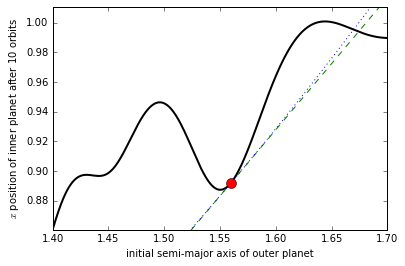

In [6]:
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.set_xlim(a_grid[0],a_grid[-1])
ax.set_ylim(np.min(x_exact),np.max(x_exact)*1.01)
ax.set_xlabel("initial semi-major axis of outer planet")
ax.set_ylabel("$x$ position of inner planet after 10 orbits")
ax.plot(a_grid, x_exact, "-", color="black", lw=2)
ax.plot(a_grid, x_1st_order, "--", color="green")
ax.plot(a_grid, x_2nd_order, ":", color="blue")
ax.plot(a_0, x, "ro",ms=10)
#plt.savefig('paper_test1.pdf',bbox_inches='tight');